In [263]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score, pairwise_distances, davies_bouldin_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import euclidean, cosine
from scipy.stats import zscore

In [264]:
def describe_data(dataframe):
    # Sprawdzenie pierwszych kilku wierszy danych
    print("Przykładowe wiersze danych:")
    print(dataframe.head())

    # Informacje o atrybutach
    print("\nInformacje o atrybutach:")
    print(dataframe.info())

    # Podstawowe statystyki opisowe
    print("\nStatystyki opisowe:")
    print(dataframe.describe())

    # Liczba unikalnych wartości dla każdego atrybutu
    print("\nLiczba unikalnych wartości dla każdego atrybutu:")
    print(dataframe.nunique())

    # Rzędy wielkości atrybutów
    print("\nRzędy wielkości atrybutów:")
    print(dataframe.apply(lambda x: 10 ** len(str(x.max()).split(".")[0]), axis=0))

    kategoryczne = dataframe.select_dtypes(include=["object"]).columns
    numeryczne = dataframe.select_dtypes(exclude=["object"]).columns

    print("Atrybuty kategoryczne:")
    print(kategoryczne)

    print("\nAtrybuty numeryczne:")
    print(numeryczne)

In [265]:
# Wczytanie danych dotyczących jakości czerwonego wina z pliku CSV
wine_data = pd.read_csv("red-wine-quality.csv")
# Opis danych
describe_data(wine_data)
# Czyszczenie danych - usunięcie wierszy zawierających brakujące wartości
wine_data = wine_data.dropna()
# Przygotowanie danych do skalowania - zastosowanie standaryzacji (zscore) na całym zestawie danych
wine_data_clean = wine_data.apply(zscore)
# Inicjalizacja obiektu skalera MinMaxScaler
min_max_scaler = MinMaxScaler()
# Przeskalowanie danych
wine_data_scaled = min_max_scaler.fit_transform(wine_data_clean)

Przykładowe wiersze danych:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8    

0.46781651342878555
0.6503072951178342
1.3820476297764526
1.94600407113734
0.8869677267400741
1.3212788383283796


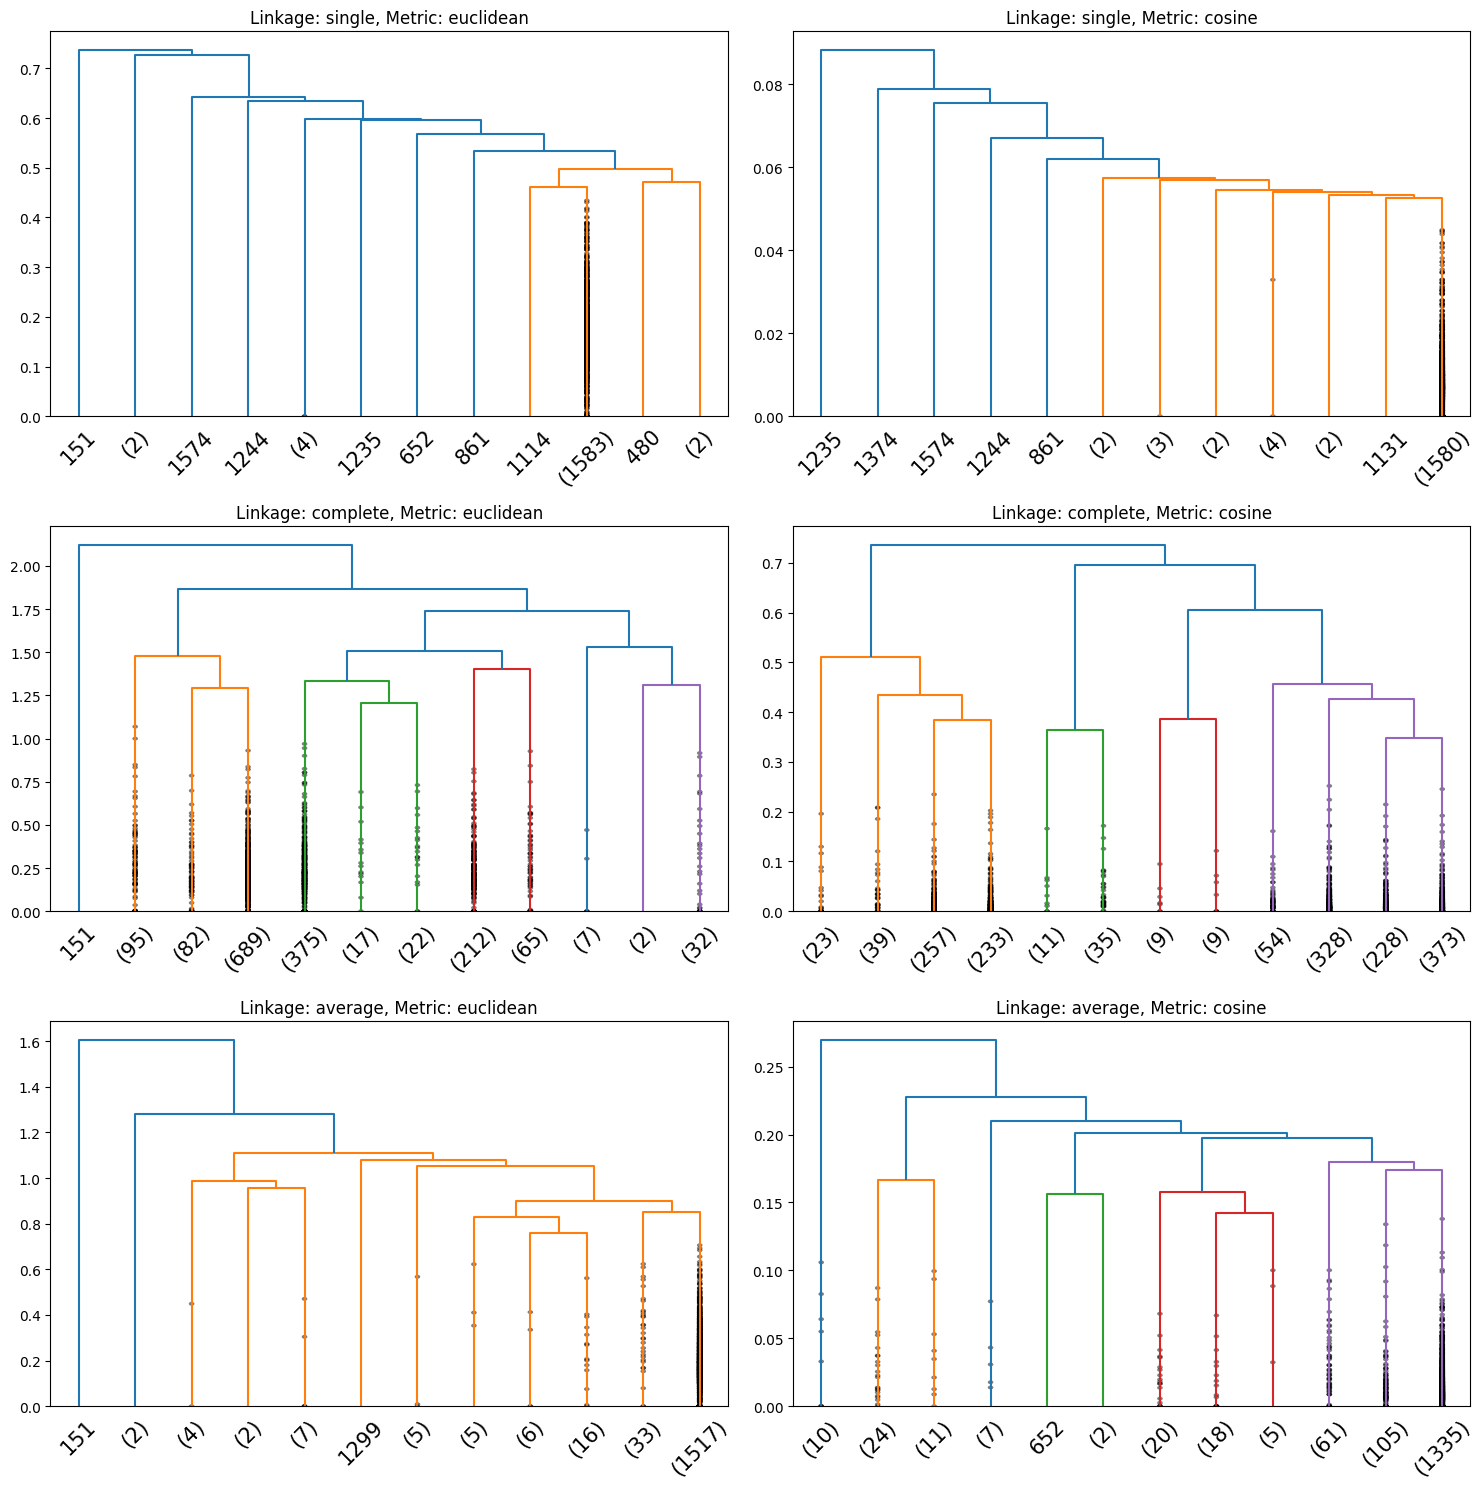

In [266]:
# Definiowanie metod łączenia i miar odległości do przetestowania
linkage_methods = ["single", "complete", "average"] # Metody łączenia
distance_metrics = ["euclidean", "cosine"] # Miary odległości
ahc_results_euclidean = {}  # Wyniki dla odległości euklidesowej
ahc_results_cosine = {}  # Wyniki dla odległości kosinusowej

# Tworzenie podwykresów dla różnych kombinacji
fig, axes = plt.subplots(len(linkage_methods), len(distance_metrics), figsize=(15, 15))

for i, linkage_method in enumerate(linkage_methods):
    for j, distance_metric in enumerate(distance_metrics):
        
        # Przeprowadzenie hierarchicznej analiza skupień
        linkage_matrix = linkage(
            wine_data_scaled, method=linkage_method, metric=distance_metric
        )

        # Przypisanie etykiet klastrów za pomocą wybranej metody
        ahc_labels = fcluster(linkage_matrix, t=12, criterion="maxclust")

        # Utworzenie dendrogramu
        dendrogram(
            linkage_matrix,
            truncate_mode="lastp",
            p=12,
            leaf_rotation=45.0,
            leaf_font_size=15.0,
            show_contracted=True,
            ax=axes[i, j],
        )
        axes[i, j].set_title(f"Linkage: {linkage_method}, Metric: {distance_metric}")
        
        # Obliczenie indeksu Daviesa-Bouldina dla oceny jakości klastrów
        db_index = davies_bouldin_score(wine_data_scaled, ahc_labels)
        if distance_metric == "euclidean":
            ahc_results_euclidean.update({linkage_method: db_index})
        else:
            ahc_results_cosine.update({linkage_method: db_index})
        print(db_index)

plt.tight_layout()
plt.show()

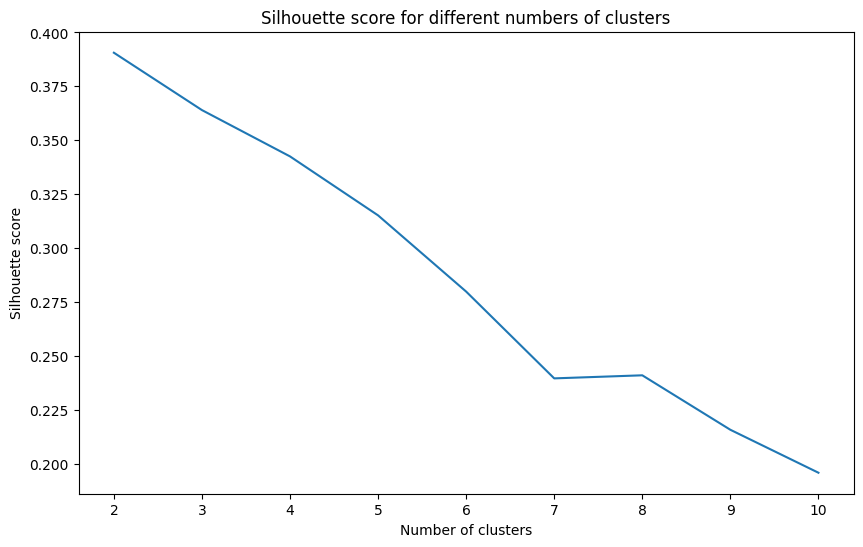

In [267]:
pca = PCA(n_components=2)
wine_data_pca = pca.fit_transform(wine_data_scaled)

# Identyfikacja optymalnej liczby klastrów
# Obliczenie silhouette score dla różnej liczby klastrów
num_clusters = range(2, 11)
silhouette_scores = []
# Przeprowadzenie klasteryzacji dla różnej liczby klastrów
for n_cluster in num_clusters:
    kmedoids = KMedoids(n_clusters=n_cluster,metric='cosine')
    kmedoids.fit(wine_data_pca)

    # Obliczenie silhouette score
    y_pred = kmedoids.predict(wine_data_pca)
    silhouette_score_val = silhouette_score(wine_data_pca, y_pred)
    silhouette_scores.append(silhouette_score_val)

# Wykres silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(num_clusters, silhouette_scores)
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.title("Silhouette score for different numbers of clusters")
plt.show()

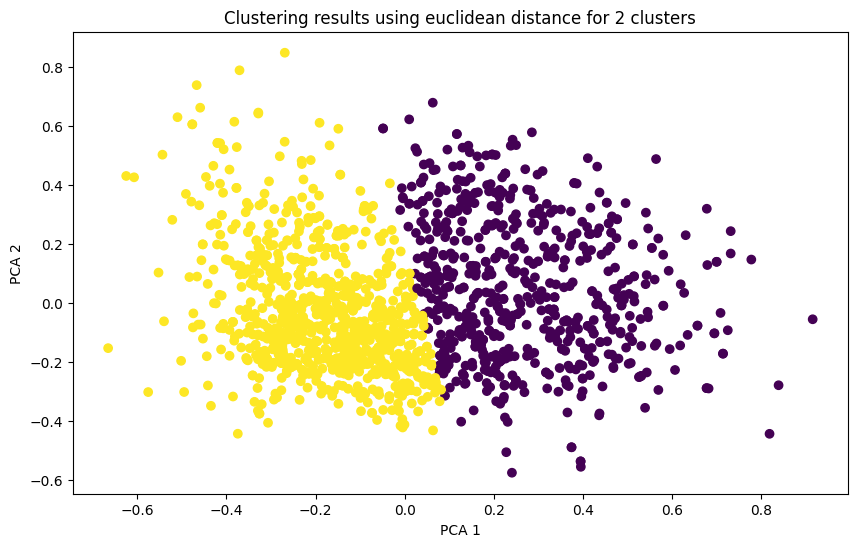

1.036196352271652


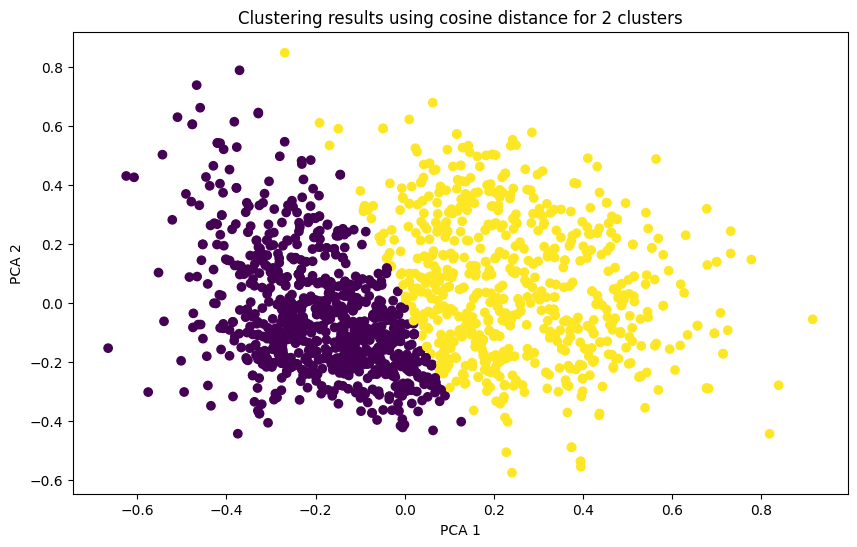

1.0526943514322162


/Users/jnowacki/Library/Python/3.9/lib/python/site-packages/sklearn_extra/cluster/_k_medoids.py:329: UserWarning: Cluster 4 is empty! self.labels_[self.medoid_indices_[4]] may not be labeled with its corresponding cluster (4).
  warnings.warn(


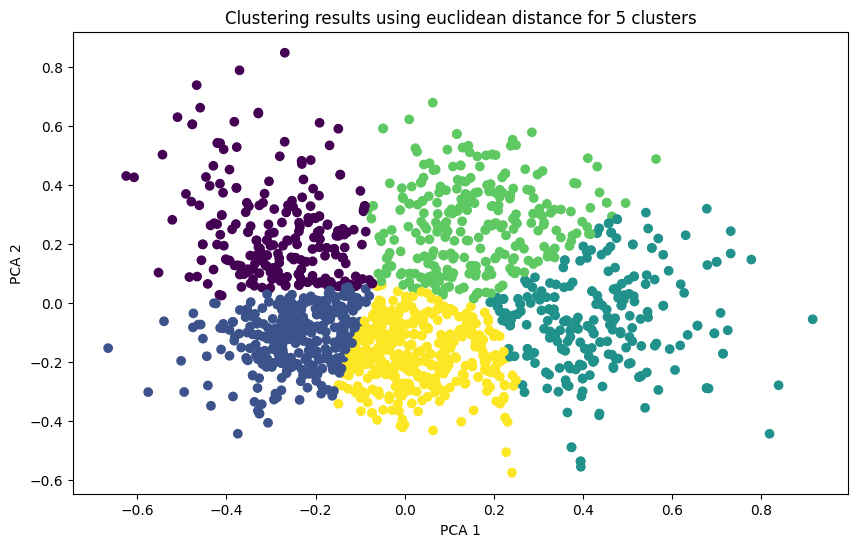

0.865861982997908


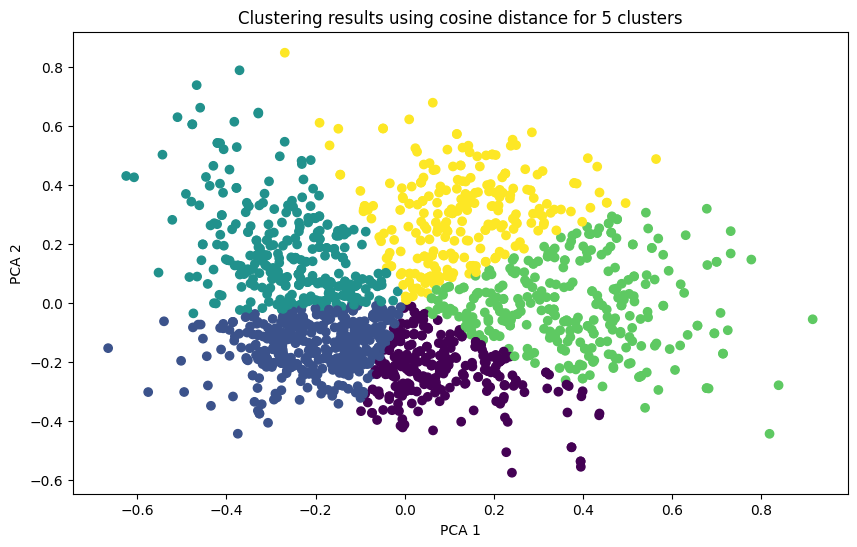

0.9251047463576402


In [268]:
n = [2, 5] # Liczba klastrów
kmedoids_results_euclidean = {}  # Wyniki dla odległości euklidesowej
kmedoids_results_cosine = {}  # Wyniki dla odległości kosinusowej

# Przeprowadzenie analizy skupień dla różnych kombinacji
for n_clusters in n:
    for distance_metric in distance_metrics:
        # Przeprowadzenie analizy skupień
        kmedoids = KMedoids(n_clusters=n_clusters, metric=distance_metric)
        # Dopasowanie modelu
        kmedoids.fit(wine_data_pca)
        KMedoidsLabels = kmedoids.predict(wine_data_pca)

        # Wizualizacja wyników analizy skupień
        plt.figure(figsize=(10, 6))
        plt.scatter(wine_data_pca[:, 0], wine_data_pca[:, 1], c=KMedoidsLabels)
        plt.xlabel("PCA 1")
        plt.ylabel("PCA 2")
        plt.title(
            "Clustering results using "
            + str(distance_metric)
            + " distance for "
            + str(n_clusters)
            + " clusters"
        )
        plt.show()

        # Obliczenie indeksu Daviesa-Bouldina dla oceny jakości klastrów
        db_index = davies_bouldin_score(wine_data_pca, KMedoidsLabels)
        if distance_metric == "euclidean":
            kmedoids_results_euclidean.update({n_clusters: db_index})
        else:
            kmedoids_results_cosine.update({n_clusters: db_index})
        print(db_index)


eps: 0.400000, min_pts: 8
Estimated number of clusters: 7
Estimated number of noise points: 1222
2.142716526793977


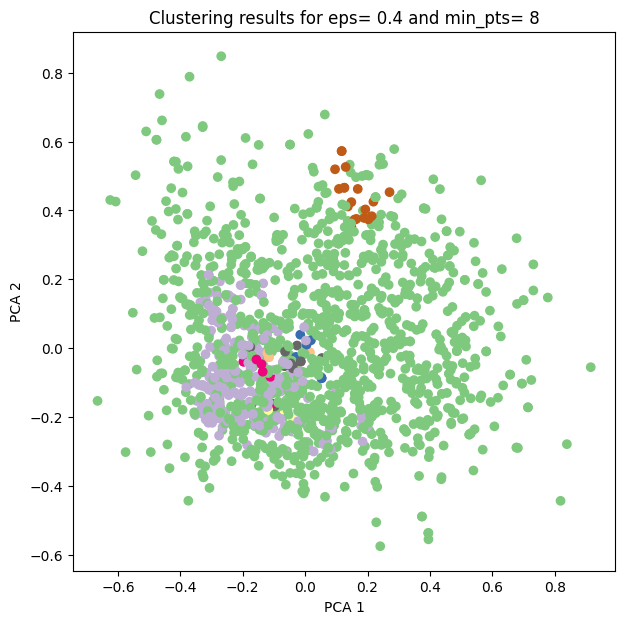

eps: 0.400000, min_pts: 18
Estimated number of clusters: 3
Estimated number of noise points: 1480
1.853753166805003


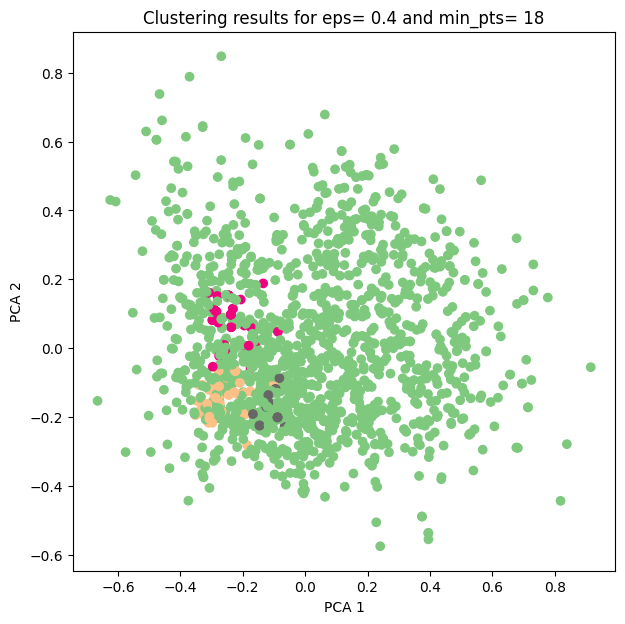

eps: 0.500000, min_pts: 8
Estimated number of clusters: 4
Estimated number of noise points: 680
3.1934861663491887


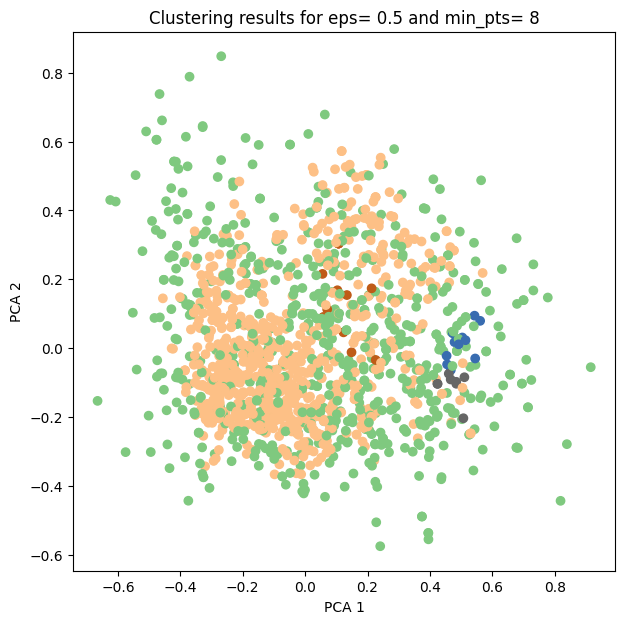

eps: 0.500000, min_pts: 18
Estimated number of clusters: 3
Estimated number of noise points: 994
2.787333294126567


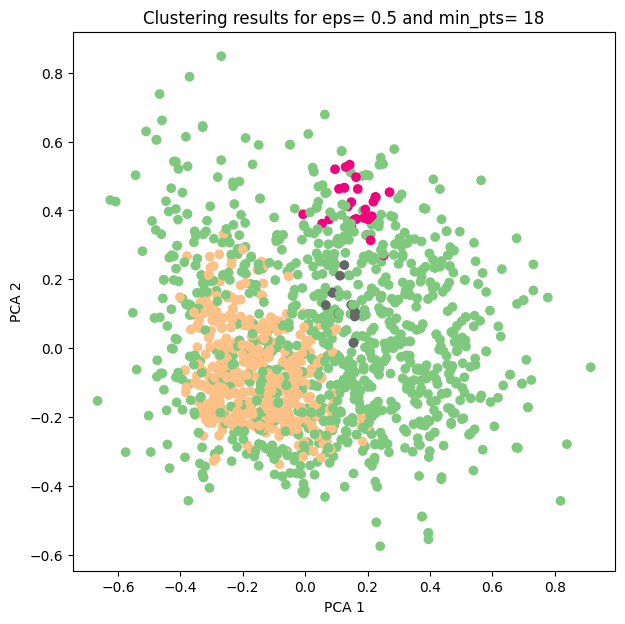

In [269]:
# epsilon_list = np.arange(0.1, 1, 0.1)
epsilon_list = [0.4, 0.5]  # Wartości Epsilon
# min_points_list = np.arange(1, 100, 1)  
min_points_list = [8, 18]  # Wartości MinPts
dbscan_results_1 = {}  # Wyniki dla eps[1]
dbscan_results_2 = {}  # Wyniki dla eps[2]

# Przeprowadzenie analizy skupień dla różnych kombinacji
for eps in epsilon_list:
    for min_pts in min_points_list:
        # Utworzenie modelu DBSCAN z epsilon i minPts
        model = DBSCAN(
            eps=eps, min_samples=min_pts, metric="cityblock", algorithm="brute"
        ).fit(wine_data_scaled)
        
        labels = model.labels_

        # Liczba klastrów i punktów odstających
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        if n_clusters_ >= 2:
            # Obliczenie indeksu Daviesa-Bouldina dla oceny jakości klastrów
            db_index = davies_bouldin_score(wine_data_scaled, labels)

            if eps == epsilon_list[0]:
                dbscan_results_1.update({min_pts: db_index})
            elif eps == epsilon_list[1]:
                dbscan_results_2.update({min_pts: db_index})

            # Wizualizacja danych za pomocą wykresu punktowego
            wine_data_clean_df = pd.DataFrame(wine_data_scaled)
            wine_data_clean_df["cluster"] = labels

            print("eps: %f, min_pts: %d" % (eps, min_pts))
            print("Estimated number of clusters: %d" % n_clusters_)
            print("Estimated number of noise points: %d" % n_noise_)
            print(db_index)

            plt.figure(figsize=(7, 7))

            plt.scatter(
                wine_data_pca[:, 0], wine_data_pca[:, 1], c=labels, cmap="Accent"
            )
            plt.xlabel("PCA 1")
            plt.ylabel("PCA 2")
            plt.title(
                "Clustering results for eps= "
                + str(eps)
                + " and min_pts= "
                + str(min_pts)
            )
            plt.show()

In [270]:
# Prezentacja wyników
print("Davies bouldin score DBSCAN results for epsilon 0.1: ")
print(dbscan_results_1)

print("Davies bouldin score DBSCAN results for epsilon 0.5: ")
print(dbscan_results_2)

print("Davies bouldin score KMedoids results for cosine: ")
print(kmedoids_results_cosine)

print("Davies bouldin score KMedoids results for euclidean: ")
print(kmedoids_results_euclidean)

print("Davies bouldin score AHC results for cosine: ")
print(ahc_results_cosine)

print("Davies bouldin score AHC results for euclidean: ")
print(ahc_results_euclidean)

Davies bouldin score DBSCAN results for epsilon 0.1: 
{8: 2.142716526793977, 18: 1.853753166805003}
Davies bouldin score DBSCAN results for epsilon 0.5: 
{8: 3.1934861663491887, 18: 2.787333294126567}
Davies bouldin score KMedoids results for cosine: 
{2: 1.0526943514322162, 5: 0.9251047463576402}
Davies bouldin score KMedoids results for euclidean: 
{2: 1.036196352271652, 5: 0.865861982997908}
Davies bouldin score AHC results for cosine: 
{'single': 0.6503072951178342, 'complete': 1.94600407113734, 'average': 1.3212788383283796}
Davies bouldin score AHC results for euclidean: 
{'single': 0.46781651342878555, 'complete': 1.3820476297764526, 'average': 0.8869677267400741}
